In [1]:
# ========================================
# 1️⃣ Imports and Config
# ========================================
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy, MeanIoU
from sklearn.metrics import f1_score

# GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Paths
IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 2000  # ✅ safe sample size
BATCH_SIZE = 4
EPOCHS = 25

# ========================================
# 2️⃣ Data Loader (Memory-Safe)
# ========================================
def load_partial_data(img_dir, mask_dir, num_samples=1000, img_size=(128,128)):
    image_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    valid_imgs = [f for f in image_files if f.endswith(('.png','.jpg','.jpeg'))]
    valid_masks = [f for f in mask_files if f.endswith(('.png','.jpg','.jpeg'))]
    
    sample_files = random.sample(list(zip(valid_imgs, valid_masks)), num_samples)
    imgs, masks = [], []

    for img_name, mask_name in tqdm(sample_files, desc="Loading Data"):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            continue

        img = cv2.resize(img, img_size) / 255.0
        mask = cv2.resize(mask, img_size) / 255.0

        imgs.append(np.expand_dims(img, -1))
        masks.append(np.expand_dims(mask, -1))

    print(f"✅ Loaded {len(imgs)} samples")
    return np.array(imgs, dtype=np.float32), np.array(masks, dtype=np.float32)

print("📥 Loading dataset...")
X, Y = load_partial_data(IMAGE_DIR, MASK_DIR, NUM_SAMPLES, IMG_SIZE)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# ========================================
# 3️⃣ Capsule Network Components
# ========================================

class Length(layers.Layer):
    """Computes vector lengths."""
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

class Squash(layers.Layer):
    """Squashing function."""
    def call(self, inputs):
        norm = tf.norm(inputs, axis=-1, keepdims=True)
        scale = (norm ** 2) / (1 + norm ** 2) / (norm + K.epsilon())
        return scale * inputs

class CapsuleLayer(layers.Layer):
    """Capsule Layer"""
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, 1)
        inputs_expand = tf.expand_dims(inputs_expand, 4)
        u_hat = tf.map_fn(lambda x: tf.matmul(self.W, x), elems=inputs_expand)
        b = tf.zeros(shape=[tf.shape(inputs)[0], self.num_capsule, self.input_num_capsule, 1, 1])

        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s = tf.reduce_sum(c * u_hat, axis=2, keepdims=True)
            v = Squash()(s)
            if i < self.routings - 1:
                b += tf.reduce_sum(u_hat * v, axis=-1, keepdims=True)
        return tf.squeeze(v, [2, 4])

# ========================================
# 4️⃣ CapsNet Architecture
# ========================================
def CapsNetSeg(input_shape=(128,128,1), n_classes=1):
    x = layers.Input(shape=input_shape)
    
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2,2))(conv1)

    conv2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)
    
    # Primary Capsules
    primary_caps = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(pool2)
    primary_caps = layers.Reshape((-1, 8))(primary_caps)
    primary_caps = Squash()(primary_caps)
    
    # Digit Capsules
    digit_caps = CapsuleLayer(num_capsule=16, dim_capsule=8, routings=3)(primary_caps)
    out_caps = Length()(digit_caps)
    
    # Decoder path for segmentation map
    decoder = layers.Reshape((16, 16, 1))(out_caps)
    up1 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), activation='relu', padding='same')(decoder)
    up2 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation='relu', padding='same')(up1)
    out = layers.Conv2D(1, (1,1), activation='sigmoid')(up2)
    
    model = models.Model(inputs=x, outputs=out)
    return model

model = CapsNetSeg()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(), MeanIoU(num_classes=2)])
model.summary()

# ========================================
# 5️⃣ Training
# ========================================
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ========================================
# 6️⃣ Evaluation Metrics
# ========================================
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
f1 = f1_score(Y_val.flatten(), y_pred_bin.flatten())
print(f"🔹 F1 Score: {f1:.4f}")

# ========================================
# 7️⃣ Plot Metrics
# ========================================
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()


📥 Loading dataset...


Loading Data: 100%|██████████| 2000/2000 [00:39<00:00, 51.24it/s]


✅ Loaded 2000 samples


ValueError: Exception encountered when calling layer "reshape_1" (type Reshape).

total size of new array must be unchanged, input_shape = [16], output_shape = [16, 16, 1]

Call arguments received by layer "reshape_1" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 16), dtype=float32)

In [3]:
# ========================================
# 4️⃣ Fixed CapsNet Architecture (Segmentation)
# ========================================
def CapsNetSeg(input_shape=(128,128,1), n_classes=1):
    x = layers.Input(shape=input_shape)
    
    # --- Encoder ---
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2,2))(conv1)   # 64x64

    conv2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)   # 32x32
    
    # --- Primary Capsules ---
    primary_caps = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(pool2)  # 16x16
    primary_caps = layers.Reshape((-1, 8))(primary_caps)
    primary_caps = Squash()(primary_caps)
    
    # --- Digit Capsules ---
    digit_caps = CapsuleLayer(num_capsule=64, dim_capsule=8, routings=3)(primary_caps)
    out_caps = Length()(digit_caps)   # shape = (None, 64)

    # --- Reshape to spatial map for segmentation ---
    decoder = layers.Reshape((8, 8, 1))(out_caps)  # 8x8 feature map
    
    # --- Decoder / Upsampling path ---
    up1 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(decoder)  # 16x16
    up2 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(up1)      # 32x32
    up3 = layers.Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(up2)      # 64x64
    up4 = layers.Conv2DTranspose(8, (3,3), strides=(2,2), activation='relu', padding='same')(up3)       # 128x128
    
    out = layers.Conv2D(1, (1,1), activation='sigmoid')(up4)
    
    model = models.Model(inputs=x, outputs=out)
    return model


# Compile Model
model = CapsNetSeg()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(), MeanIoU(num_classes=2)])
model.summary()


ValueError: Exception encountered when calling layer "capsule_layer_2" (type CapsuleLayer).

in user code:

    File "C:\Users\HP-PC\AppData\Local\Temp\ipykernel_13700\3015941311.py", line 99, in call  *
        u_hat = tf.einsum('bijc,njdc->bnid', inputs_expand, self.W)

    ValueError: Shape must be rank 4 but is rank 5
    	 for 0th input and equation: bijc,njdc->bnid for '{{node capsule_layer_2/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="bijc,njdc->bnid"](capsule_layer_2/ExpandDims_1, capsule_layer_2/einsum/Einsum/ReadVariableOp)' with input shapes: [?,1,1024,8,1], [64,1024,8,8].


Call arguments received by layer "capsule_layer_2" (type CapsuleLayer):
  • inputs=tf.Tensor(shape=(None, 1024, 8), dtype=float32)

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall, AUC, MeanIoU

# ========================================
# Capsule Helper Functions
# ========================================
class Squash(layers.Layer):
    """Squashing function for capsule normalization"""
    def call(self, s, axis=-1):
        s_norm = tf.norm(s, axis=axis, keepdims=True)
        scale = (s_norm ** 2) / (1 + s_norm ** 2)
        return scale * (s / (s_norm + tf.keras.backend.epsilon()))

class CapsuleLayer(layers.Layer):
    """Fully Connected Capsule Layer"""
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        # Weight matrix for transforming input capsules
        self.W = self.add_weight(
            shape=[self.input_num_capsule, self.num_capsule, 
                   self.input_dim_capsule, self.dim_capsule],
            initializer="glorot_uniform",
            trainable=True,
            name='W'
        )

    def call(self, inputs):
        # Expand dims for broadcasting
        inputs_expand = tf.expand_dims(tf.expand_dims(inputs, 2), 2)
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        # Transform inputs by W
        u_hat = tf.einsum('bijp,ijkl->bikl', inputs, self.W)

        # Routing algorithm
        b = tf.zeros_like(u_hat[..., 0])
        for _ in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            s = tf.reduce_sum(c[..., tf.newaxis] * u_hat, axis=1)
            v = Squash()(s)
            if _ < self.routings - 1:
                b += tf.reduce_sum(u_hat * v[:, tf.newaxis, :, :], axis=-1)
        return v

class Length(layers.Layer):
    """Compute the length (magnitude) of capsule vectors."""
    def call(self, inputs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), axis=-1) + tf.keras.backend.epsilon())

# ========================================
# 4️⃣ Fixed CapsNet Architecture (Segmentation)
# ========================================
def CapsNetSeg(input_shape=(128,128,1), n_classes=1):
    x = layers.Input(shape=input_shape)
    
    # --- Encoder ---
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2,2))(conv1)   # 64x64

    conv2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)   # 32x32
    
    # --- Primary Capsules ---
    primary_caps = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(pool2)  # 16x16
    primary_caps = layers.Reshape((-1, 8))(primary_caps)
    primary_caps = Squash()(primary_caps)
    
    # --- Digit Capsules ---
    digit_caps = CapsuleLayer(num_capsule=64, dim_capsule=8, routings=3)(primary_caps)
    out_caps = Length()(digit_caps)   # shape = (None, 64)

    # --- Reshape to spatial map for segmentation ---
    decoder = layers.Reshape((8, 8, 1))(out_caps)  # Convert 64 → 8x8 feature map
    
    # --- Decoder / Upsampling path ---
    up1 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(decoder)  # 16x16
    up2 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(up1)      # 32x32
    up3 = layers.Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(up2)      # 64x64
    up4 = layers.Conv2DTranspose(8, (3,3), strides=(2,2), activation='relu', padding='same')(up3)       # 128x128
    
    out = layers.Conv2D(1, (1,1), activation='sigmoid')(up4)
    
    model = models.Model(inputs=x, outputs=out)
    return model

# ========================================
# Compile Model
# ========================================
model = CapsNetSeg()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC(), MeanIoU(num_classes=2)]
)

model.summary()


ValueError: Exception encountered when calling layer "capsule_layer_3" (type CapsuleLayer).

in user code:

    File "C:\Users\HP-PC\AppData\Local\Temp\ipykernel_13700\2991160978.py", line 42, in call  *
        u_hat = tf.einsum('bijp,ijkl->bikl', inputs, self.W)

    ValueError: Shape must be rank 4 but is rank 3
    	 for 0th input and equation: bijp,ijkl->bikl for '{{node capsule_layer_3/einsum/Einsum}} = Einsum[N=2, T=DT_FLOAT, equation="bijp,ijkl->bikl"](Placeholder, capsule_layer_3/einsum/Einsum/ReadVariableOp)' with input shapes: [?,1024,8], [1024,64,8,8].


Call arguments received by layer "capsule_layer_3" (type CapsuleLayer):
  • inputs=tf.Tensor(shape=(None, 1024, 8), dtype=float32)

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import Precision, Recall, AUC, MeanIoU

# ---------- Helper layers ----------
class Squash(layers.Layer):
    """Squash non-linearity for capsules: acts on the last axis (capsule dimension)."""
    def call(self, inputs, axis=-1):
        sq_norm = tf.reduce_sum(tf.square(inputs), axis=axis, keepdims=True)
        scale = sq_norm / (1.0 + sq_norm)
        return scale * inputs / (tf.sqrt(sq_norm) + K.epsilon())

class Length(layers.Layer):
    """Compute length (L2 norm) of capsule vectors along last axis."""
    def call(self, inputs, **kwargs):
        return tf.sqrt(tf.reduce_sum(tf.square(inputs), -1) + K.epsilon())

# ---------- Fixed CapsuleLayer ----------
class CapsuleLayer(layers.Layer):
    """
    Expects inputs shaped (batch, num_input_caps, dim_input).
    Returns (batch, num_capsule, dim_capsule).
    Implementation uses tf.einsum to transform inputs with W shaped:
      (num_input_caps, num_capsule, dim_input, dim_capsule)
    Routing follows Sabour et al. with 'routings' iterations.
    """
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        # input_shape: (batch, input_num_caps, input_dim)
        self.input_num_capsule = int(input_shape[1])
        self.input_dim_capsule = int(input_shape[2])
        # Weight shape: (input_num_caps, num_capsule, input_dim, dim_capsule)
        self.W = self.add_weight(
            shape=(self.input_num_capsule, self.num_capsule,
                   self.input_dim_capsule, self.dim_capsule),
            initializer='glorot_uniform',
            trainable=True,
            name='W_caps'
        )
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs, training=None):
        # inputs: (B, N, D)
        # W: (N, K, D, O)
        # u_hat: (B, N, K, O)  where K=num_capsule, O=dim_capsule
        u_hat = tf.einsum('bnd,nkdo->bnko', inputs, self.W)

        # routing logits: b shape (B, N, K)
        b = tf.zeros(shape=(tf.shape(inputs)[0], self.input_num_capsule, self.num_capsule), dtype=tf.float32)

        for i in range(self.routings):
            # coupling coefficients, softmax across output capsules (axis=2)
            c = tf.nn.softmax(b, axis=2)  # (B, N, K)
            # weighted sum over input capsules: s_k = sum_i c_ik * u_hat_ik
            # Expand c for multiplication: (B, N, K, 1)
            s = tf.reduce_sum(tf.expand_dims(c, -1) * u_hat, axis=1)  # (B, K, O)
            v = Squash()(s)  # (B, K, O)
            if i < self.routings - 1:
                # agreement: u_hat dot v -> (B, N, K)
                # expand v to (B, 1, K, O) to multiply with u_hat (B,N,K,O)
                agreement = tf.reduce_sum(u_hat * tf.expand_dims(v, 1), axis=-1)  # (B, N, K)
                b = b + agreement

        return v  # (B, K, O)

# ---------- Model definition (CapsNetSeg) ----------
def CapsNetSeg(input_shape=(128,128,1), n_classes=1):
    x = layers.Input(shape=input_shape)

    # encoder
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    conv1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2,2))(conv1)   # 64x64

    conv2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2,2))(conv2)   # 32x32

    # primary capsules: reduce spatial -> (16x16) if stride=2 from 32x32
    primary = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(pool2)  # (B,16,16,32)
    # map to capsule vectors of dim 8
    pcs = layers.Conv2D(8, (1,1), padding='same', activation=None)(primary)  # (B,16,16,8)
    pcs_reshaped = layers.Reshape((16*16, 8))(pcs)  # (B, 256, 8)
    primary_caps = Squash()(pcs_reshaped)  # (B, 256, 8)

    # digit/higher capsules
    digit_caps = CapsuleLayer(num_capsule=64, dim_capsule=8, routings=3)(primary_caps)  # (B,64,8)
    out_caps_len = Length()(digit_caps)  # (B,64)  lengths

    # reshape lengths into a small spatial map:
    # we need elements = 64 → choose a spatial arrangement 8x8 (64)
    decoder = layers.Reshape((8, 8, 1))(out_caps_len)  # (B,8,8,1)

    # decode / upsample to original resolution
    up1 = layers.Conv2DTranspose(64, (3,3), strides=(2,2), activation='relu', padding='same')(decoder)  # 16x16
    up2 = layers.Conv2DTranspose(32, (3,3), strides=(2,2), activation='relu', padding='same')(up1)     # 32x32
    up3 = layers.Conv2DTranspose(16, (3,3), strides=(2,2), activation='relu', padding='same')(up2)     # 64x64
    up4 = layers.Conv2DTranspose(8,  (3,3), strides=(2,2), activation='relu', padding='same')(up3)     # 128x128

    out = layers.Conv2D(1, (1,1), activation='sigmoid')(up4)

    model = models.Model(inputs=x, outputs=out, name='CapsNetSeg_fixed')
    return model

# ---------- compile & summary ----------
model = CapsNetSeg()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC(), MeanIoU(num_classes=2)])
model.summary()


Model: "CapsNetSeg_fixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                              

In [7]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 20000
BATCH_SIZE = 4          # CapsNet can handle slightly larger batches
EPOCHS = 25
CHECKPOINT_PATH = "best_capsnet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# CapsNet Components
# ----------------------------
def squash(vectors, axis=-1):
    """Squashing function for capsule outputs"""
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class PrimaryCaps(layers.Layer):
    def _init_(self, num_caps, dim_caps, kernel_size=9, strides=2, padding='valid', **kwargs):
        super(PrimaryCaps, self)._init_(**kwargs)
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            self.num_caps * self.dim_caps,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            activation='relu'
        )
        super(PrimaryCaps, self).build(input_shape)
    
    def call(self, inputs):
        outputs = self.conv(inputs)
        batch_size = tf.shape(outputs)[0]
        h = tf.shape(outputs)[1]
        w = tf.shape(outputs)[2]
        
        outputs = tf.reshape(outputs, [batch_size, h, w, self.num_caps, self.dim_caps])
        outputs = squash(outputs)
        return outputs
    
    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class CapsuleLayer(layers.Layer):
    def _init_(self, num_caps, dim_caps, routings=3, **kwargs):
        super(CapsuleLayer, self)._init_(**kwargs)
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.routings = routings
    
    def build(self, input_shape):
        self.input_num_caps = input_shape[-2]
        self.input_dim_caps = input_shape[-1]
        
        self.W = self.add_weight(
            shape=[self.num_caps, self.input_num_caps, 
                   self.dim_caps, self.input_dim_caps],
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
        
        inputs_tiled = tf.expand_dims(inputs, axis=-2)
        inputs_tiled = tf.expand_dims(inputs_tiled, axis=3)
        inputs_tiled = tf.tile(inputs_tiled, [1, 1, 1, self.num_caps, 1, 1])
        
        W_tiled = tf.tile(self.W, [batch_size * h * w, 1, 1, 1, 1])
        W_tiled = tf.reshape(W_tiled, [batch_size, h, w, self.num_caps, 
                                       self.input_num_caps, self.dim_caps, 
                                       self.input_dim_caps])
        
        u_hat = tf.einsum('bhwnijk,bhwnij->bhwnik', W_tiled, inputs_tiled)
        
        b = tf.zeros([batch_size, h, w, self.num_caps, self.input_num_caps])
        
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=3)
            c_expanded = tf.expand_dims(c, axis=-1)
            s = tf.reduce_sum(c_expanded * u_hat, axis=4)
            v = squash(s)
            
            if i < self.routings - 1:
                v_expanded = tf.expand_dims(v, axis=4)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b = b + agreement
        
        return v
    
    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'routings': self.routings
        })
        return config

# ----------------------------
# CapsNet Segmentation Model
# ----------------------------
def capsnet_seg_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, 5, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Primary capsules
    primary_caps = PrimaryCaps(num_caps=8, dim_caps=8, kernel_size=5, 
                               strides=2, padding='same')(x)
    
    # Capsule layers
    caps = CapsuleLayer(num_caps=16, dim_caps=16, routings=3)(primary_caps)
    
    # Get capsule lengths for segmentation
    caps_length = tf.sqrt(tf.reduce_sum(tf.square(caps), axis=-1, keepdims=True))
    
    # Decoder path
    x = layers.Reshape((-1, caps_length.shape[1] * caps_length.shape[2] * caps_length.shape[3]))(caps_length)
    x = layers.Reshape((caps_length.shape[1], caps_length.shape[2], caps_length.shape[3]))(x)
    
    # Upsampling path
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    
    # Final segmentation output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = capsnet_seg_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop]
)

# ----------------------------
# Evaluation Metrics
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Collect predictions
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*60)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                           val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

for step in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    if (step + 1) % 50 == 0:
        print(f"Processed {step + 1}/{validation_steps} batches...")

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# Flatten for pixel-wise metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Calculate all metrics
print("\n" + "="*60)
print("PIXEL-WISE METRICS")
print("="*60)

accuracy = np.mean(y_true_flat == y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
specificity = specificity_score(y_true_flat, y_pred_flat)

try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")

# Image-wise metrics
print("\n" + "="*60)
print("IMAGE-WISE METRICS")
print("="*60)

dice_scores = [dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]
iou_scores = [iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]

dice = np.mean(dice_scores)
iou = np.mean(iou_scores)

print(f"Dice Coefficient: {dice:.4f} ± {np.std(dice_scores):.4f}")
print(f"IoU (Jaccard):    {iou:.4f} ± {np.std(iou_scores):.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                          target_names=['Background', 'Liver'], 
                          digits=4))

# ----------------------------
# Visualization
# ----------------------------
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample predictions visualization
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 4, figsize=(14, 4*n_show))

if n_show == 1:
    axs = axs.reshape(1, -1)

val_iter_img = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                                val_indices[:n_show], 1, IMG_SIZE, shuffle=False)

for i in range(n_show):
    # Get original input image
    Xb_show, _ = next(val_iter_img)
    input_img = Xb_show[0].squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze() > 0.5).astype(np.uint8)
    
    # Calculate metrics for this sample
    dice_i = dice_coef_np(y_trues[i], y_preds_probs[i]>0.5)
    iou_i = iou_np(y_trues[i], y_preds_probs[i]>0.5)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title(f'Input Image {i+1}', fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontweight='bold')
    
    # Overlay
    overlay = np.zeros((*input_img.shape, 3))
    overlay[:,:,0] = gt  # Ground truth in red
    overlay[:,:,1] = pred  # Prediction in green
    axs[i,3].imshow(overlay)
    axs[i,3].set_title(f'Overlay\nDice: {dice_i:.3f}, IoU: {iou_i:.3f}', fontweight='bold')
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING & EVALUATION COMPLETE")
print("="*60)
print(f"Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"\nFinal Results:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  Dice:       {dice:.4f}")
print(f"  IoU:        {iou:.4f}")
print(f"  AUC:        {auc:.4f}")
print("="*60)
print("✅ All metrics computed and visualizations saved!")

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 4000 Validation steps: 1000


TypeError: ('Keyword argument not understood:', 'num_caps')

In [11]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 20000
BATCH_SIZE = 4          # CapsNet can handle slightly larger batches
EPOCHS = 25
CHECKPOINT_PATH = "best_capsnet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# CapsNet Components
# ----------------------------
def squash(vectors, axis=-1):
    """Squashing function for capsule outputs"""
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class PrimaryCaps(layers.Layer):
    def __init__(self, num_caps=8, dim_caps=8, kernel_size=9, strides=2, padding='valid', **kwargs):
        super(PrimaryCaps, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            self.num_caps * self.dim_caps,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            activation='relu'
        )
        super(PrimaryCaps, self).build(input_shape)
    
    def call(self, inputs):
        outputs = self.conv(inputs)
        batch_size = tf.shape(outputs)[0]
        h = tf.shape(outputs)[1]
        w = tf.shape(outputs)[2]
        
        outputs = tf.reshape(outputs, [batch_size, h, w, self.num_caps, self.dim_caps])
        outputs = squash(outputs)
        return outputs
    
    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class CapsuleLayer(layers.Layer):
    def __init__(self, num_caps=16, dim_caps=16, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.routings = routings
    
    def build(self, input_shape):
        self.input_num_caps = input_shape[-2]
        self.input_dim_caps = input_shape[-1]
        
        self.W = self.add_weight(
            shape=[self.num_caps, self.input_num_caps, 
                   self.dim_caps, self.input_dim_caps],
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)
    
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
        
        inputs_tiled = tf.expand_dims(inputs, axis=-2)
        inputs_tiled = tf.expand_dims(inputs_tiled, axis=3)
        inputs_tiled = tf.tile(inputs_tiled, [1, 1, 1, self.num_caps, 1, 1])
        
        W_tiled = tf.tile(self.W, [batch_size * h * w, 1, 1, 1, 1])
        W_tiled = tf.reshape(W_tiled, [batch_size, h, w, self.num_caps, 
                                       self.input_num_caps, self.dim_caps, 
                                       self.input_dim_caps])
        
        u_hat = tf.einsum('bhwnijk,bhwnij->bhwnik', W_tiled, inputs_tiled)
        
        b = tf.zeros([batch_size, h, w, self.num_caps, self.input_num_caps])
        
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=3)
            c_expanded = tf.expand_dims(c, axis=-1)
            s = tf.reduce_sum(c_expanded * u_hat, axis=4)
            v = squash(s)
            
            if i < self.routings - 1:
                v_expanded = tf.expand_dims(v, axis=4)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b = b + agreement
        
        return v
    
    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'routings': self.routings
        })
        return config

# ----------------------------
# CapsNet Segmentation Model
# ----------------------------
def capsnet_seg_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, 5, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Primary capsules
    primary_caps = PrimaryCaps(num_caps=8, dim_caps=8, kernel_size=5, 
                               strides=2, padding='same')(x)
    
    # Capsule layers
    caps = CapsuleLayer(num_caps=16, dim_caps=16, routings=3)(primary_caps)
    
    # Get capsule lengths for segmentation
    caps_length = tf.sqrt(tf.reduce_sum(tf.square(caps), axis=-1, keepdims=True))
    
    # Decoder path
    x = layers.Reshape((-1, caps_length.shape[1] * caps_length.shape[2] * caps_length.shape[3]))(caps_length)
    x = layers.Reshape((caps_length.shape[1], caps_length.shape[2], caps_length.shape[3]))(x)
    
    # Upsampling path
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    
    # Final segmentation output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = capsnet_seg_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop]
)

# ----------------------------
# Evaluation Metrics
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Collect predictions
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*60)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                           val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

for step in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    if (step + 1) % 50 == 0:
        print(f"Processed {step + 1}/{validation_steps} batches...")

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# Flatten for pixel-wise metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Calculate all metrics
print("\n" + "="*60)
print("PIXEL-WISE METRICS")
print("="*60)

accuracy = np.mean(y_true_flat == y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
specificity = specificity_score(y_true_flat, y_pred_flat)

try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")

# Image-wise metrics
print("\n" + "="*60)
print("IMAGE-WISE METRICS")
print("="*60)

dice_scores = [dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]
iou_scores = [iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]

dice = np.mean(dice_scores)
iou = np.mean(iou_scores)

print(f"Dice Coefficient: {dice:.4f} ± {np.std(dice_scores):.4f}")
print(f"IoU (Jaccard):    {iou:.4f} ± {np.std(iou_scores):.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                          target_names=['Background', 'Liver'], 
                          digits=4))

# ----------------------------
# Visualization
# ----------------------------
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample predictions visualization
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 4, figsize=(14, 4*n_show))

if n_show == 1:
    axs = axs.reshape(1, -1)

val_iter_img = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                                val_indices[:n_show], 1, IMG_SIZE, shuffle=False)

for i in range(n_show):
    # Get original input image
    Xb_show, _ = next(val_iter_img)
    input_img = Xb_show[0].squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze() > 0.5).astype(np.uint8)
    
    # Calculate metrics for this sample
    dice_i = dice_coef_np(y_trues[i], y_preds_probs[i]>0.5)
    iou_i = iou_np(y_trues[i], y_preds_probs[i]>0.5)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title(f'Input Image {i+1}', fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontweight='bold')
    
    # Overlay
    overlay = np.zeros((*input_img.shape, 3))
    overlay[:,:,0] = gt  # Ground truth in red
    overlay[:,:,1] = pred  # Prediction in green
    axs[i,3].imshow(overlay)
    axs[i,3].set_title(f'Overlay\nDice: {dice_i:.3f}, IoU: {iou_i:.3f}', fontweight='bold')
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING & EVALUATION COMPLETE")
print("="*60)
print(f"Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"\nFinal Results:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  Dice:       {dice:.4f}")
print(f"  IoU:        {iou:.4f}")
print(f"  AUC:        {auc:.4f}")
print("="*60)
print("✅ All metrics computed and visualizations saved!")

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 4000 Validation steps: 1000


ValueError: Exception encountered when calling layer "capsule_layer_3" (type CapsuleLayer).

in user code:

    File "C:\Users\HP-PC\AppData\Local\Temp\ipykernel_26296\1632822140.py", line 193, in call  *
        inputs_tiled = tf.tile(inputs_tiled, [1, 1, 1, self.num_caps, 1, 1])

    ValueError: Shape must be rank 7 but is rank 6 for '{{node capsule_layer_3/Tile}} = Tile[T=DT_FLOAT, Tmultiples=DT_INT32](capsule_layer_3/ExpandDims_1, capsule_layer_3/Tile/multiples)' with input shapes: [?,64,64,1,8,1,8], [6].


Call arguments received by layer "capsule_layer_3" (type CapsuleLayer):
  • inputs=tf.Tensor(shape=(None, 64, 64, 8, 8), dtype=float32)

In [12]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (128, 128)
NUM_SAMPLES = 20000
BATCH_SIZE = 4          # CapsNet can handle slightly larger batches
EPOCHS = 25
CHECKPOINT_PATH = "best_capsnet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# CapsNet Components
# ----------------------------
def squash(vectors, axis=-1):
    """Squashing function for capsule outputs"""
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class PrimaryCaps(layers.Layer):
    def __init__(self, num_caps=8, dim_caps=8, kernel_size=9, strides=2, padding='valid', **kwargs):
        super(PrimaryCaps, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            self.num_caps * self.dim_caps,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            activation='relu'
        )
        super(PrimaryCaps, self).build(input_shape)
    
    def call(self, inputs):
        outputs = self.conv(inputs)
        batch_size = tf.shape(outputs)[0]
        h = tf.shape(outputs)[1]
        w = tf.shape(outputs)[2]
        
        outputs = tf.reshape(outputs, [batch_size, h, w, self.num_caps, self.dim_caps])
        outputs = squash(outputs)
        return outputs
    
    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class CapsuleLayer(layers.Layer):
    def __init__(self, num_caps=16, dim_caps=16, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.routings = routings
    
    def build(self, input_shape):
        self.input_num_caps = input_shape[-2]
        self.input_dim_caps = input_shape[-1]
        
        self.W = self.add_weight(
            shape=[self.num_caps, self.input_num_caps, 
                   self.dim_caps, self.input_dim_caps],
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch, h, w, input_num_caps, input_dim_caps)
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
        
        # Expand dims for broadcasting: (batch, h, w, 1, input_num_caps, input_dim_caps)
        inputs_expanded = tf.expand_dims(inputs, axis=3)
        
        # Tile to match num_caps: (batch, h, w, num_caps, input_num_caps, input_dim_caps)
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, 1, self.num_caps, 1, 1])
        
        # Expand W for batch processing: (1, 1, 1, num_caps, input_num_caps, dim_caps, input_dim_caps)
        W_expanded = tf.reshape(self.W, [1, 1, 1, self.num_caps, self.input_num_caps, 
                                         self.dim_caps, self.input_dim_caps])
        
        # Compute predictions: u_hat (batch, h, w, num_caps, input_num_caps, dim_caps)
        # inputs_tiled: (batch, h, w, num_caps, input_num_caps, input_dim_caps)
        # W: (num_caps, input_num_caps, dim_caps, input_dim_caps)
        inputs_tiled_expanded = tf.expand_dims(inputs_tiled, axis=-2)  # Add dim for matrix mul
        u_hat = tf.reduce_sum(inputs_tiled_expanded * W_expanded, axis=-1)
        
        # Dynamic routing
        b = tf.zeros([batch_size, h, w, self.num_caps, self.input_num_caps])
        
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=3)
            c_expanded = tf.expand_dims(c, axis=-1)
            
            # Weighted sum: (batch, h, w, num_caps, dim_caps)
            s = tf.reduce_sum(c_expanded * u_hat, axis=4)
            
            # Squash
            v = squash(s, axis=-1)
            
            if i < self.routings - 1:
                # Update routing weights
                v_expanded = tf.expand_dims(v, axis=4)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b = b + agreement
        
        return v
    
    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'routings': self.routings
        })
        return config

# ----------------------------
# CapsNet Segmentation Model
# ----------------------------
def capsnet_seg_model(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution
    x = layers.Conv2D(64, 5, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Primary capsules
    primary_caps = PrimaryCaps(num_caps=8, dim_caps=8, kernel_size=5, 
                               strides=2, padding='same')(x)
    
    # Capsule layers
    caps = CapsuleLayer(num_caps=16, dim_caps=16, routings=3)(primary_caps)
    
    # Get capsule lengths for segmentation
    caps_length = tf.sqrt(tf.reduce_sum(tf.square(caps), axis=-1, keepdims=True))
    
    # Decoder path
    x = layers.Reshape((-1, caps_length.shape[1] * caps_length.shape[2] * caps_length.shape[3]))(caps_length)
    x = layers.Reshape((caps_length.shape[1], caps_length.shape[2], caps_length.shape[3]))(x)
    
    # Upsampling path
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    
    # Final segmentation output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = capsnet_seg_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop]
)

# ----------------------------
# Evaluation Metrics
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Collect predictions
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*60)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                           val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

for step in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    if (step + 1) % 50 == 0:
        print(f"Processed {step + 1}/{validation_steps} batches...")

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# Flatten for pixel-wise metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Calculate all metrics
print("\n" + "="*60)
print("PIXEL-WISE METRICS")
print("="*60)

accuracy = np.mean(y_true_flat == y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
specificity = specificity_score(y_true_flat, y_pred_flat)

try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")

# Image-wise metrics
print("\n" + "="*60)
print("IMAGE-WISE METRICS")
print("="*60)

dice_scores = [dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]
iou_scores = [iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]

dice = np.mean(dice_scores)
iou = np.mean(iou_scores)

print(f"Dice Coefficient: {dice:.4f} ± {np.std(dice_scores):.4f}")
print(f"IoU (Jaccard):    {iou:.4f} ± {np.std(iou_scores):.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                          target_names=['Background', 'Liver'], 
                          digits=4))

# ----------------------------
# Visualization
# ----------------------------
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample predictions visualization
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 4, figsize=(14, 4*n_show))

if n_show == 1:
    axs = axs.reshape(1, -1)

val_iter_img = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                                val_indices[:n_show], 1, IMG_SIZE, shuffle=False)

for i in range(n_show):
    # Get original input image
    Xb_show, _ = next(val_iter_img)
    input_img = Xb_show[0].squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze() > 0.5).astype(np.uint8)
    
    # Calculate metrics for this sample
    dice_i = dice_coef_np(y_trues[i], y_preds_probs[i]>0.5)
    iou_i = iou_np(y_trues[i], y_preds_probs[i]>0.5)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title(f'Input Image {i+1}', fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontweight='bold')
    
    # Overlay
    overlay = np.zeros((*input_img.shape, 3))
    overlay[:,:,0] = gt  # Ground truth in red
    overlay[:,:,1] = pred  # Prediction in green
    axs[i,3].imshow(overlay)
    axs[i,3].set_title(f'Overlay\nDice: {dice_i:.3f}, IoU: {iou_i:.3f}', fontweight='bold')
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING & EVALUATION COMPLETE")
print("="*60)
print(f"Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"\nFinal Results:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  Dice:       {dice:.4f}")
print(f"  IoU:        {iou:.4f}")
print(f"  AUC:        {auc:.4f}")
print("="*60)
print("✅ All metrics computed and visualizations saved!")

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 4000 Validation steps: 1000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      1664      
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 primary_caps_4 (PrimaryCaps  (None, 64, 64, 8, 8)     102464    
 )                                                               
                                                                 
 capsule_layer_4 (CapsuleLay  (None, 64, 64, 16, 16)   16384     
 er)            

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/capsule_layer_4/mul/Mul' defined at (most recent call last):
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP-PC\AppData\Local\Temp\ipykernel_26296\3828346949.py", line 300, in <module>
      history = model.fit(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/capsule_layer_4/mul/Mul'
failed to allocate memory
	 [[{{node gradient_tape/model/capsule_layer_4/mul/Mul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3990]

In [13]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (64, 64)  # Reduced from 128x128 to save memory
NUM_SAMPLES = 20000
BATCH_SIZE = 2          # Reduced batch size for memory
EPOCHS = 25
CHECKPOINT_PATH = "best_capsnet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# CapsNet Components
# ----------------------------
def squash(vectors, axis=-1):
    """Squashing function for capsule outputs"""
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class PrimaryCaps(layers.Layer):
    def __init__(self, num_caps=8, dim_caps=8, kernel_size=9, strides=2, padding='valid', **kwargs):
        super(PrimaryCaps, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            self.num_caps * self.dim_caps,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            activation='relu'
        )
        super(PrimaryCaps, self).build(input_shape)
    
    def call(self, inputs):
        outputs = self.conv(inputs)
        batch_size = tf.shape(outputs)[0]
        h = tf.shape(outputs)[1]
        w = tf.shape(outputs)[2]
        
        outputs = tf.reshape(outputs, [batch_size, h, w, self.num_caps, self.dim_caps])
        outputs = squash(outputs)
        return outputs
    
    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class CapsuleLayer(layers.Layer):
    def __init__(self, num_caps=16, dim_caps=16, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.routings = routings
    
    def build(self, input_shape):
        self.input_num_caps = input_shape[-2]
        self.input_dim_caps = input_shape[-1]
        
        self.W = self.add_weight(
            shape=[self.num_caps, self.input_num_caps, 
                   self.dim_caps, self.input_dim_caps],
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch, h, w, input_num_caps, input_dim_caps)
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
        
        # Flatten spatial dimensions to reduce memory
        inputs_reshaped = tf.reshape(inputs, [batch_size, h * w, self.input_num_caps, self.input_dim_caps])
        
        # Expand dims for broadcasting: (batch, hw, 1, input_num_caps, input_dim_caps)
        inputs_expanded = tf.expand_dims(inputs_reshaped, axis=2)
        
        # Tile to match num_caps: (batch, hw, num_caps, input_num_caps, input_dim_caps)
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_caps, 1, 1])
        
        # Expand W: (1, 1, num_caps, input_num_caps, dim_caps, input_dim_caps)
        W_expanded = tf.reshape(self.W, [1, 1, self.num_caps, self.input_num_caps, 
                                         self.dim_caps, self.input_dim_caps])
        
        # Compute predictions: u_hat (batch, hw, num_caps, input_num_caps, dim_caps)
        inputs_tiled_expanded = tf.expand_dims(inputs_tiled, axis=-2)
        u_hat = tf.reduce_sum(inputs_tiled_expanded * W_expanded, axis=-1)
        
        # Dynamic routing
        b = tf.zeros([batch_size, h * w, self.num_caps, self.input_num_caps])
        
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expanded = tf.expand_dims(c, axis=-1)
            
            # Weighted sum: (batch, hw, num_caps, dim_caps)
            s = tf.reduce_sum(c_expanded * u_hat, axis=3)
            
            # Squash
            v = squash(s, axis=-1)
            
            if i < self.routings - 1:
                # Update routing weights
                v_expanded = tf.expand_dims(v, axis=3)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b = b + agreement
        
        # Reshape back to spatial dimensions
        v = tf.reshape(v, [batch_size, h, w, self.num_caps, self.dim_caps])
        return v
    
    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'routings': self.routings
        })
        return config

# ----------------------------
# CapsNet Segmentation Model (Memory Optimized)
# ----------------------------
def capsnet_seg_model(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution - reduced filters
    x = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)  # Downsample early to save memory
    
    # Primary capsules - reduced dimensions
    primary_caps = PrimaryCaps(num_caps=4, dim_caps=4, kernel_size=3, 
                               strides=2, padding='same')(x)
    
    # Capsule layers - reduced dimensions
    caps = CapsuleLayer(num_caps=8, dim_caps=8, routings=2)(primary_caps)  # Reduced routings
    
    # Get capsule lengths for segmentation
    caps_length = tf.sqrt(tf.reduce_sum(tf.square(caps), axis=-1, keepdims=True))
    
    # Decoder path
    x = layers.Reshape((-1, caps_length.shape[1] * caps_length.shape[2] * caps_length.shape[3]))(caps_length)
    x = layers.Reshape((caps_length.shape[1], caps_length.shape[2], caps_length.shape[3]))(x)
    
    # Upsampling path - simplified
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(8, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(8, 3, padding='same', activation='relu')(x)
    
    # Final segmentation output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = capsnet_seg_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop]
)

# ----------------------------
# Evaluation Metrics
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Collect predictions
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*60)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                           val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

for step in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    if (step + 1) % 50 == 0:
        print(f"Processed {step + 1}/{validation_steps} batches...")

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# Flatten for pixel-wise metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Calculate all metrics
print("\n" + "="*60)
print("PIXEL-WISE METRICS")
print("="*60)

accuracy = np.mean(y_true_flat == y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
specificity = specificity_score(y_true_flat, y_pred_flat)

try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")

# Image-wise metrics
print("\n" + "="*60)
print("IMAGE-WISE METRICS")
print("="*60)

dice_scores = [dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]
iou_scores = [iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]

dice = np.mean(dice_scores)
iou = np.mean(iou_scores)

print(f"Dice Coefficient: {dice:.4f} ± {np.std(dice_scores):.4f}")
print(f"IoU (Jaccard):    {iou:.4f} ± {np.std(iou_scores):.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                          target_names=['Background', 'Liver'], 
                          digits=4))

# ----------------------------
# Visualization
# ----------------------------
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample predictions visualization
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 4, figsize=(14, 4*n_show))

if n_show == 1:
    axs = axs.reshape(1, -1)

val_iter_img = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                                val_indices[:n_show], 1, IMG_SIZE, shuffle=False)

for i in range(n_show):
    # Get original input image
    Xb_show, _ = next(val_iter_img)
    input_img = Xb_show[0].squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze() > 0.5).astype(np.uint8)
    
    # Calculate metrics for this sample
    dice_i = dice_coef_np(y_trues[i], y_preds_probs[i]>0.5)
    iou_i = iou_np(y_trues[i], y_preds_probs[i]>0.5)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title(f'Input Image {i+1}', fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontweight='bold')
    
    # Overlay
    overlay = np.zeros((*input_img.shape, 3))
    overlay[:,:,0] = gt  # Ground truth in red
    overlay[:,:,1] = pred  # Prediction in green
    axs[i,3].imshow(overlay)
    axs[i,3].set_title(f'Overlay\nDice: {dice_i:.3f}, IoU: {iou_i:.3f}', fontweight='bold')
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING & EVALUATION COMPLETE")
print("="*60)
print(f"Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"\nFinal Results:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  Dice:       {dice:.4f}")
print(f"  IoU:        {iou:.4f}")
print(f"  AUC:        {auc:.4f}")
print("="*60)
print("✅ All metrics computed and visualizations saved!")

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 8000 Validation steps: 2000
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 primary_caps_5 (PrimaryCaps  (None, 16, 16, 4, 4)     4624      
 )            

InvalidArgumentError: Graph execution error:

Detected at node 'binary_crossentropy/logistic_loss/mul' defined at (most recent call last):
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 519, in dispatch_queue
      await self.process_one()
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 508, in process_one
      await dispatch(*args)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute
      res = shell.run_cell(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP-PC\AppData\Local\Temp\ipykernel_26296\987427286.py", line 303, in <module>
      history = model.fit(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
      backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\HP-PC\miniconda3\envs\newenv\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
      return tf.nn.sigmoid_cross_entropy_with_logits(
Node: 'binary_crossentropy/logistic_loss/mul'
required broadcastable shapes
	 [[{{node binary_crossentropy/logistic_loss/mul}}]] [Op:__inference_train_function_6644]

✅ GPU memory growth enabled
Train: 16000, Val: 4000, Total: 20000
Steps per epoch: 8000 Validation steps: 2000
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 64, 64, 32)   320         ['input_11[0][0]']               
                                                                                                  
 batch_normalization_11 (BatchN  (None, 64, 64, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                

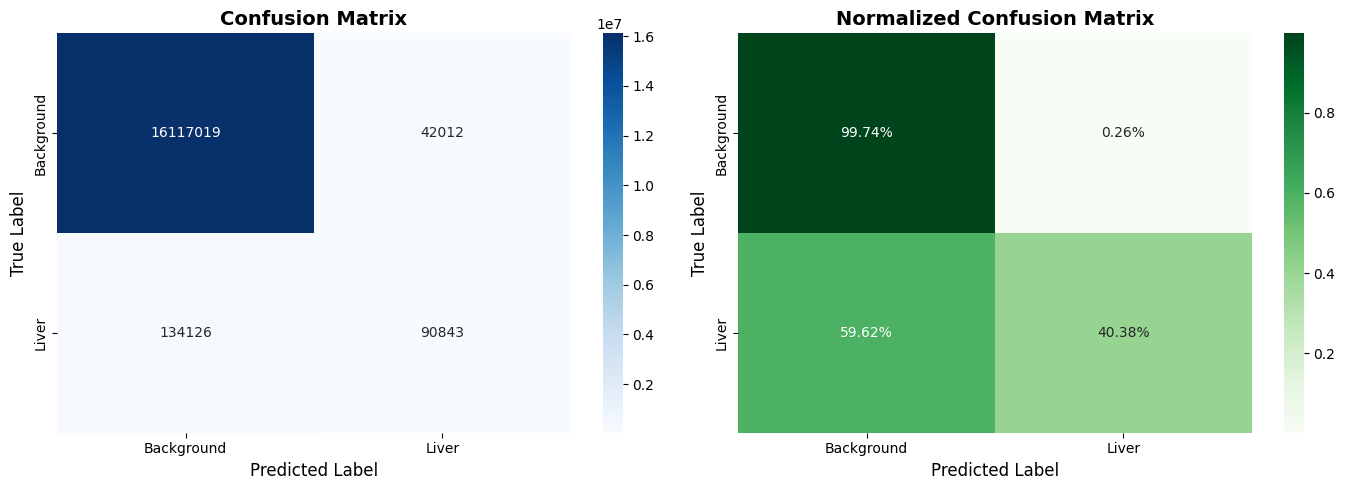

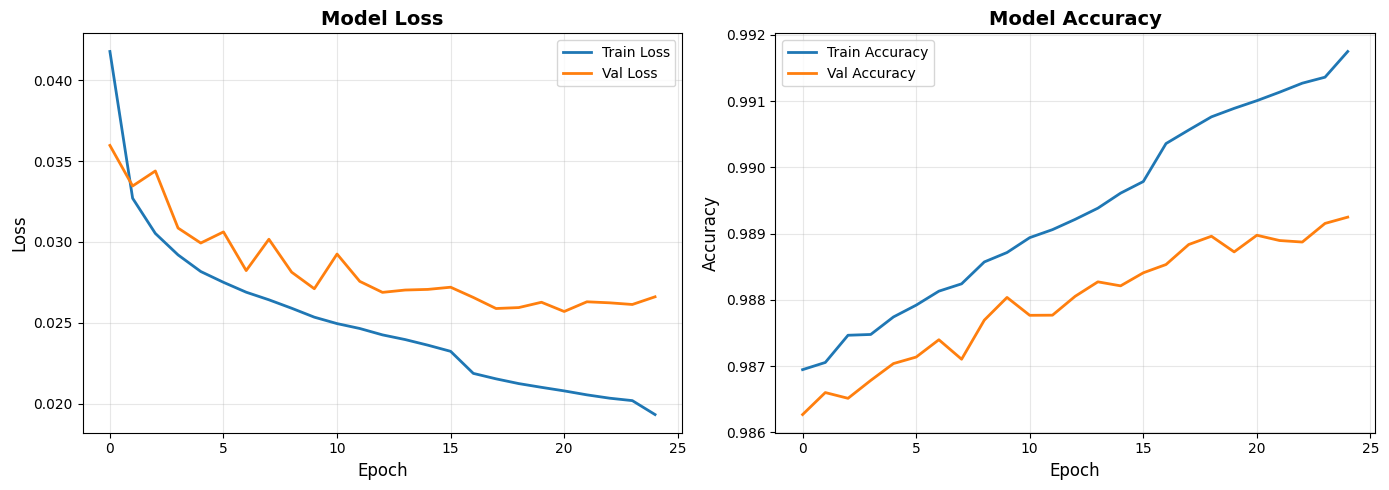

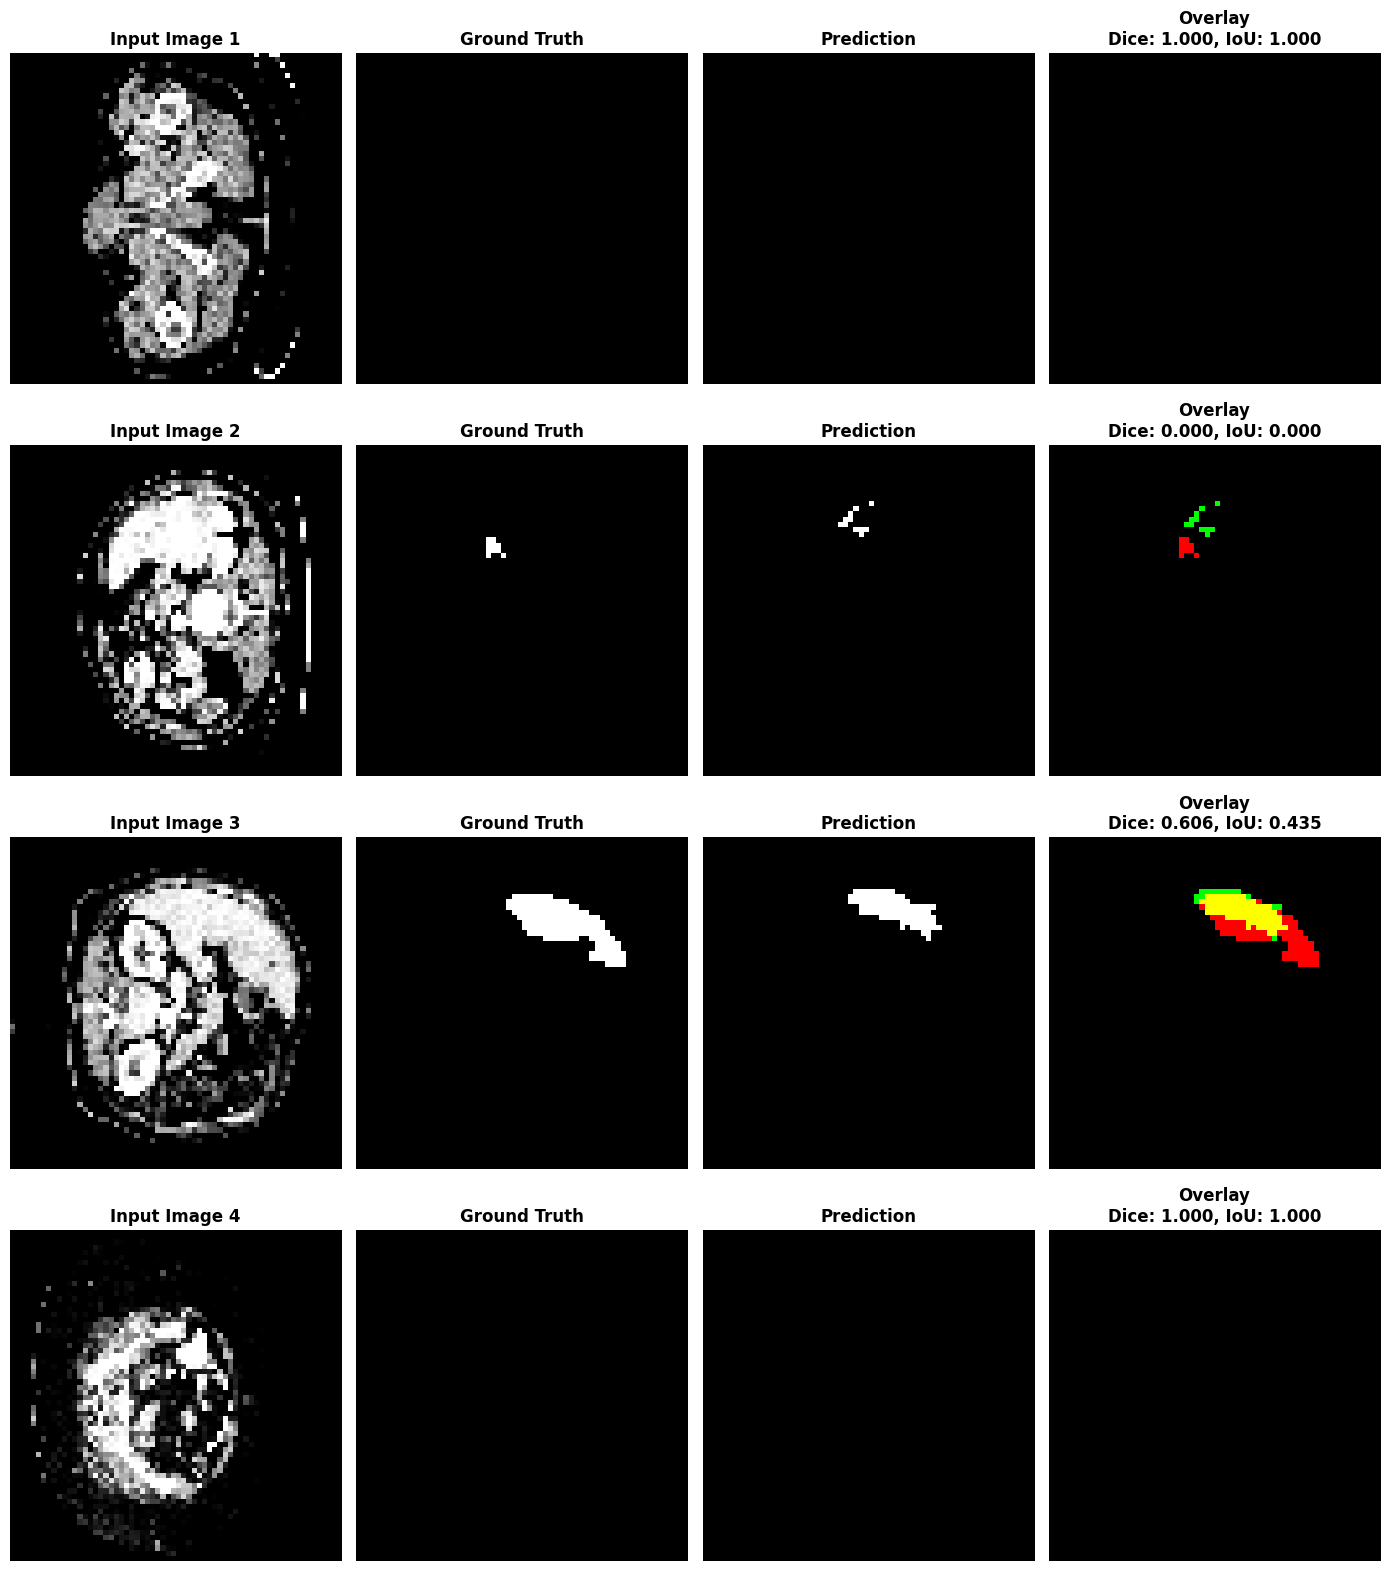


TRAINING & EVALUATION COMPLETE
Best checkpoint saved at: best_capsnet_checkpoint.h5

Final Results:
  Accuracy:   0.9892
  Precision:  0.6838
  Recall:     0.4038
  F1-Score:   0.5078
  Dice:       0.7665
  IoU:        0.7357
  AUC:        0.9898
✅ All metrics computed and visualizations saved!


In [14]:
import os
import random
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, backend as K
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)

# ----------------------------
# Config
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMAGE_DIR = r"E:\CDownloads\LiverDataset\images"
MASK_DIR  = r"E:\CDownloads\LiverDataset\masks"
IMG_SIZE = (64, 64)  # Reduced from 128x128 to save memory
NUM_SAMPLES = 20000
BATCH_SIZE = 2          # Reduced batch size for memory
EPOCHS = 25
CHECKPOINT_PATH = "best_capsnet_checkpoint.h5"
PRED_SAMPLES_TO_SHOW = 4

# ----------------------------
# Enable GPU memory growth
# ----------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except Exception as e:
        print("⚠ GPU memory growth failed:", e)
else:
    print("⚠ No GPU detected, using CPU")

# ----------------------------
# Load file paths
# ----------------------------
def collect_sample_indices(image_dir, mask_dir, num_samples):
    imgs = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    masks = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))])
    total = min(len(imgs), len(masks))
    if total == 0:
        raise ValueError("No images/masks found. Check paths.")
    all_indices = list(range(total))
    chosen = random.sample(all_indices, min(num_samples, total))
    chosen.sort()
    return imgs, masks, chosen

imgs_list, masks_list, chosen_indices = collect_sample_indices(IMAGE_DIR, MASK_DIR, NUM_SAMPLES)

# ----------------------------
# Train/Val split
# ----------------------------
val_ratio = 0.2
num_chosen = len(chosen_indices)
num_val = int(math.ceil(val_ratio * num_chosen))
num_train = num_chosen - num_val

random.shuffle(chosen_indices)
train_indices = chosen_indices[:num_train]
val_indices = chosen_indices[num_train:]
print(f"Train: {len(train_indices)}, Val: {len(val_indices)}, Total: {num_chosen}")

# ----------------------------
# Data generator
# ----------------------------
def preprocess_image(path, img_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Can't read {path}")
    img = cv2.resize(img, img_size)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=-1)

def mask_to_binary(mask_arr):
    return (mask_arr >= 0.5).astype(np.float32)

def batch_generator(image_dir, mask_dir, imgs_list, masks_list, index_list, batch_size, img_size, shuffle=True):
    n = len(index_list)
    while True:
        if shuffle:
            random.shuffle(index_list)
        for i in range(0, n, batch_size):
            batch_idx = index_list[i:i+batch_size]
            Xb, Yb = [], []
            for idx in batch_idx:
                img_path = os.path.join(image_dir, imgs_list[idx])
                mask_path = os.path.join(mask_dir, masks_list[idx])
                try:
                    img = preprocess_image(img_path, img_size)
                    mask = preprocess_image(mask_path, img_size)
                except Exception as e:
                    print("Skipping:", e)
                    continue
                Xb.append(img)
                Yb.append(mask_to_binary(mask))
            if len(Xb) == 0:
                continue
            yield np.stack(Xb, axis=0).astype(np.float32), np.stack(Yb, axis=0).astype(np.float32)

train_gen = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, train_indices, BATCH_SIZE, IMG_SIZE, shuffle=True)
val_gen   = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

steps_per_epoch = math.ceil(len(train_indices) / BATCH_SIZE)
validation_steps = math.ceil(len(val_indices) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch, "Validation steps:", validation_steps)

# ----------------------------
# CapsNet Components
# ----------------------------
def squash(vectors, axis=-1):
    """Squashing function for capsule outputs"""
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class PrimaryCaps(layers.Layer):
    def __init__(self, num_caps=8, dim_caps=8, kernel_size=9, strides=2, padding='valid', **kwargs):
        super(PrimaryCaps, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
    def build(self, input_shape):
        self.conv = layers.Conv2D(
            self.num_caps * self.dim_caps,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            activation='relu'
        )
        super(PrimaryCaps, self).build(input_shape)
    
    def call(self, inputs):
        outputs = self.conv(inputs)
        batch_size = tf.shape(outputs)[0]
        h = tf.shape(outputs)[1]
        w = tf.shape(outputs)[2]
        
        outputs = tf.reshape(outputs, [batch_size, h, w, self.num_caps, self.dim_caps])
        outputs = squash(outputs)
        return outputs
    
    def get_config(self):
        config = super(PrimaryCaps, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'kernel_size': self.kernel_size,
            'strides': self.strides,
            'padding': self.padding
        })
        return config

class CapsuleLayer(layers.Layer):
    def __init__(self, num_caps=16, dim_caps=16, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__()
        self.num_caps = num_caps
        self.dim_caps = dim_caps
        self.routings = routings
    
    def build(self, input_shape):
        self.input_num_caps = input_shape[-2]
        self.input_dim_caps = input_shape[-1]
        
        self.W = self.add_weight(
            shape=[self.num_caps, self.input_num_caps, 
                   self.dim_caps, self.input_dim_caps],
            initializer='glorot_uniform',
            trainable=True,
            name='W'
        )
        super(CapsuleLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch, h, w, input_num_caps, input_dim_caps)
        batch_size = tf.shape(inputs)[0]
        h = tf.shape(inputs)[1]
        w = tf.shape(inputs)[2]
        
        # Flatten spatial dimensions to reduce memory
        inputs_reshaped = tf.reshape(inputs, [batch_size, h * w, self.input_num_caps, self.input_dim_caps])
        
        # Expand dims for broadcasting: (batch, hw, 1, input_num_caps, input_dim_caps)
        inputs_expanded = tf.expand_dims(inputs_reshaped, axis=2)
        
        # Tile to match num_caps: (batch, hw, num_caps, input_num_caps, input_dim_caps)
        inputs_tiled = tf.tile(inputs_expanded, [1, 1, self.num_caps, 1, 1])
        
        # Expand W: (1, 1, num_caps, input_num_caps, dim_caps, input_dim_caps)
        W_expanded = tf.reshape(self.W, [1, 1, self.num_caps, self.input_num_caps, 
                                         self.dim_caps, self.input_dim_caps])
        
        # Compute predictions: u_hat (batch, hw, num_caps, input_num_caps, dim_caps)
        inputs_tiled_expanded = tf.expand_dims(inputs_tiled, axis=-2)
        u_hat = tf.reduce_sum(inputs_tiled_expanded * W_expanded, axis=-1)
        
        # Dynamic routing
        b = tf.zeros([batch_size, h * w, self.num_caps, self.input_num_caps])
        
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)
            c_expanded = tf.expand_dims(c, axis=-1)
            
            # Weighted sum: (batch, hw, num_caps, dim_caps)
            s = tf.reduce_sum(c_expanded * u_hat, axis=3)
            
            # Squash
            v = squash(s, axis=-1)
            
            if i < self.routings - 1:
                # Update routing weights
                v_expanded = tf.expand_dims(v, axis=3)
                agreement = tf.reduce_sum(u_hat * v_expanded, axis=-1)
                b = b + agreement
        
        # Reshape back to spatial dimensions
        v = tf.reshape(v, [batch_size, h, w, self.num_caps, self.dim_caps])
        return v
    
    def get_config(self):
        config = super(CapsuleLayer, self).get_config()
        config.update({
            'num_caps': self.num_caps,
            'dim_caps': self.dim_caps,
            'routings': self.routings
        })
        return config

# ----------------------------
# CapsNet Segmentation Model (Memory Optimized)
# ----------------------------
def capsnet_seg_model(input_shape=(64, 64, 1)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial convolution - reduced filters
    x = layers.Conv2D(32, 3, strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)  # 64 -> 32
    
    # Primary capsules - reduced dimensions
    primary_caps = PrimaryCaps(num_caps=4, dim_caps=4, kernel_size=3, 
                               strides=2, padding='same')(x)  # 32 -> 16
    
    # Capsule layers - reduced dimensions
    caps = CapsuleLayer(num_caps=8, dim_caps=8, routings=2)(primary_caps)  # 16x16x8x8
    
    # Get capsule lengths for segmentation
    caps_length = tf.sqrt(tf.reduce_sum(tf.square(caps), axis=-1) + K.epsilon())  # 16x16x8
    
    # Merge capsule dimension into channels
    batch_size = tf.shape(caps_length)[0]
    h = tf.shape(caps_length)[1]
    w = tf.shape(caps_length)[2]
    x = tf.reshape(caps_length, [batch_size, h, w, 8])  # 16x16x8
    
    # Upsampling path to match input size (64x64)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)  # 16 -> 32
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(16, 4, strides=2, padding='same', activation='relu')(x)  # 32 -> 64
    x = layers.Conv2D(8, 3, padding='same', activation='relu')(x)
    
    # Final segmentation output
    outputs = layers.Conv2D(1, 1, activation='sigmoid', dtype='float32')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build model
model = capsnet_seg_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1))
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ----------------------------
# Callbacks
# ----------------------------
cb_checkpoint = callbacks.ModelCheckpoint(
    CHECKPOINT_PATH, monitor='val_loss', save_best_only=True, verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)
cb_earlystop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# ----------------------------
# Train
# ----------------------------
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[cb_checkpoint, cb_reduce_lr, cb_earlystop]
)

# ----------------------------
# Evaluation Metrics
# ----------------------------
def dice_coef_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    return (2*np.sum(y_true_f*y_pred_f)+smooth)/(np.sum(y_true_f)+np.sum(y_pred_f)+smooth)

def iou_np(y_true, y_pred, smooth=1e-7):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f*y_pred_f)
    union = np.sum(y_true_f)+np.sum(y_pred_f)-inter
    return (inter+smooth)/(union+smooth)

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Collect predictions
print("\n" + "="*60)
print("EVALUATING MODEL ON VALIDATION SET")
print("="*60)

y_trues, y_preds_probs = [], []
val_iter = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                           val_indices, BATCH_SIZE, IMG_SIZE, shuffle=False)

for step in range(validation_steps):
    Xb, Yb = next(val_iter)
    preds = model.predict(Xb, verbose=0)
    y_trues.append(Yb)
    y_preds_probs.append(preds)
    if (step + 1) % 50 == 0:
        print(f"Processed {step + 1}/{validation_steps} batches...")

y_trues = np.concatenate(y_trues, axis=0)
y_preds_probs = np.concatenate(y_preds_probs, axis=0)

# Flatten for pixel-wise metrics
y_true_flat = (y_trues.flatten() > 0.5).astype(np.uint8)
y_pred_prob_flat = y_preds_probs.flatten()
y_pred_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Calculate all metrics
print("\n" + "="*60)
print("PIXEL-WISE METRICS")
print("="*60)

accuracy = np.mean(y_true_flat == y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
specificity = specificity_score(y_true_flat, y_pred_flat)

try:
    auc = roc_auc_score(y_true_flat, y_pred_prob_flat)
except:
    auc = float('nan')

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score:    {f1:.4f}")
print(f"AUC:         {auc:.4f}")

# Image-wise metrics
print("\n" + "="*60)
print("IMAGE-WISE METRICS")
print("="*60)

dice_scores = [dice_coef_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]
iou_scores = [iou_np(y_trues[i], y_preds_probs[i]>0.5) for i in range(y_trues.shape[0])]

dice = np.mean(dice_scores)
iou = np.mean(iou_scores)

print(f"Dice Coefficient: {dice:.4f} ± {np.std(dice_scores):.4f}")
print(f"IoU (Jaccard):    {iou:.4f} ± {np.std(iou_scores):.4f}")

# Confusion Matrix
print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_true_flat, y_pred_flat)
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives:  {cm[1,1]:,}")

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true_flat, y_pred_flat, 
                          target_names=['Background', 'Liver'], 
                          digits=4))

# ----------------------------
# Visualization
# ----------------------------
# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Background', 'Liver'],
            yticklabels=['Background', 'Liver'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Sample predictions visualization
n_show = min(PRED_SAMPLES_TO_SHOW, y_trues.shape[0])
fig, axs = plt.subplots(n_show, 4, figsize=(14, 4*n_show))

if n_show == 1:
    axs = axs.reshape(1, -1)

val_iter_img = batch_generator(IMAGE_DIR, MASK_DIR, imgs_list, masks_list, 
                                val_indices[:n_show], 1, IMG_SIZE, shuffle=False)

for i in range(n_show):
    # Get original input image
    Xb_show, _ = next(val_iter_img)
    input_img = Xb_show[0].squeeze()
    
    gt = y_trues[i].squeeze()
    pred = (y_preds_probs[i].squeeze() > 0.5).astype(np.uint8)
    
    # Calculate metrics for this sample
    dice_i = dice_coef_np(y_trues[i], y_preds_probs[i]>0.5)
    iou_i = iou_np(y_trues[i], y_preds_probs[i]>0.5)
    
    axs[i,0].imshow(input_img, cmap='gray')
    axs[i,0].set_title(f'Input Image {i+1}', fontweight='bold')
    
    axs[i,1].imshow(gt, cmap='gray')
    axs[i,1].set_title('Ground Truth', fontweight='bold')
    
    axs[i,2].imshow(pred, cmap='gray')
    axs[i,2].set_title('Prediction', fontweight='bold')
    
    # Overlay
    overlay = np.zeros((*input_img.shape, 3))
    overlay[:,:,0] = gt  # Ground truth in red
    overlay[:,:,1] = pred  # Prediction in green
    axs[i,3].imshow(overlay)
    axs[i,3].set_title(f'Overlay\nDice: {dice_i:.3f}, IoU: {iou_i:.3f}', fontweight='bold')
    
    for ax in axs[i]:
        ax.axis('off')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------
# Summary
# ----------------------------
print("\n" + "="*60)
print("TRAINING & EVALUATION COMPLETE")
print("="*60)
print(f"Best checkpoint saved at: {CHECKPOINT_PATH}")
print(f"\nFinal Results:")
print(f"  Accuracy:   {accuracy:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1-Score:   {f1:.4f}")
print(f"  Dice:       {dice:.4f}")
print(f"  IoU:        {iou:.4f}")
print(f"  AUC:        {auc:.4f}")
print("="*60)
print("✅ All metrics computed and visualizations saved!")